<a href="https://colab.research.google.com/github/michalcik10/SUNS_zadanie1_Steamhry/blob/main/zad3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import os
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.optimizers as optimizer
import matplotlib.pyplot as pl
from google.colab.patches import cv2_imshow
import numpy
import pandas as pd
import plotly.figure_factory as ffc

from PIL import Image
from sklearn.pipeline import make_pipeline
from tensorflow.python.keras import backend as kb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

In [47]:
im_w =128 
im_h = 128
train_data_dir = '/content/drive/MyDrive/data-z3/train'
validation_data_dir = '/content/drive/MyDrive/data-z3/valid'
test_data_dir = '/content/drive/MyDrive/data-z3/test'
batch_size = 20

In [48]:
class_names = os.listdir(train_data_dir)
print(class_names)
print("Number of Classess:",len(class_names))

['giant slalom', 'snow boarding', 'lacrosse', 'surfing', 'bobsled', 'pole climbing', 'arm wrestling', 'golf', 'parallel bar', 'shuffleboard', 'baton twirling', 'uneven bars', 'pole vault', 'water cycling', 'roller derby', 'mushing', 'weightlifting', 'rowing', 'barell racing', 'hydroplane racing', 'field hockey', 'harness racing', 'football', 'canoe slamon', 'jousting', 'shot put', 'sidecar racing', 'disc golf', 'air hockey', 'sky surfing', 'motorcycle racing', 'baseball', 'ice yachting', 'ski jumping', 'cricket', 'horse racing', 'figure skating women', 'javelin', 'bowling', 'billiards', 'figure skating men', 'tug of war', 'horse jumping', 'basketball', 'frisbee', 'sumo wrestling', 'fly fishing', 'cheerleading', 'sailboat racing', 'bull riding', 'rock climbing', 'balance beam', 'polo', 'water polo', 'figure skating pairs', 'volleyball', 'rollerblade racing', 'high jump', 'hang gliding', 'formula 1 racing', 'hockey', 'table tennis', 'pommel horse', 'rugby', 'wingsuit flying', 'ampute foo

In [49]:
import cv2
for direct in class_names:
    im = cv2.imread(test_data_dir + '/' + direct + '/' + os.listdir(test_data_dir + '/' + direct)[0])
    #cv2_imshow(im)


In [131]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  image_size=(im_h, im_w),
  batch_size=batch_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_data_dir, 
    image_size=(im_h, im_w),
    batch_size=batch_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data_dir, image_size=(im_w, im_h), batch_size=batch_size, shuffle=False)


Found 13619 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [51]:
print(train_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [50]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [51]:
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(im_w, im_h),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)

Found 13619 images belonging to 100 classes.


In [52]:
validation_generator = train_datagen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(im_w, im_h),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)

Found 500 images belonging to 100 classes.


In [9]:
test_generator = train_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(im_w, im_h),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

Found 500 images belonging to 100 classes.


In [53]:
class_names = list(train_generator.class_indices.keys()) 
print(class_names)

['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing', 'roller 

In [134]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [137]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(im_h,
                                  im_w,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

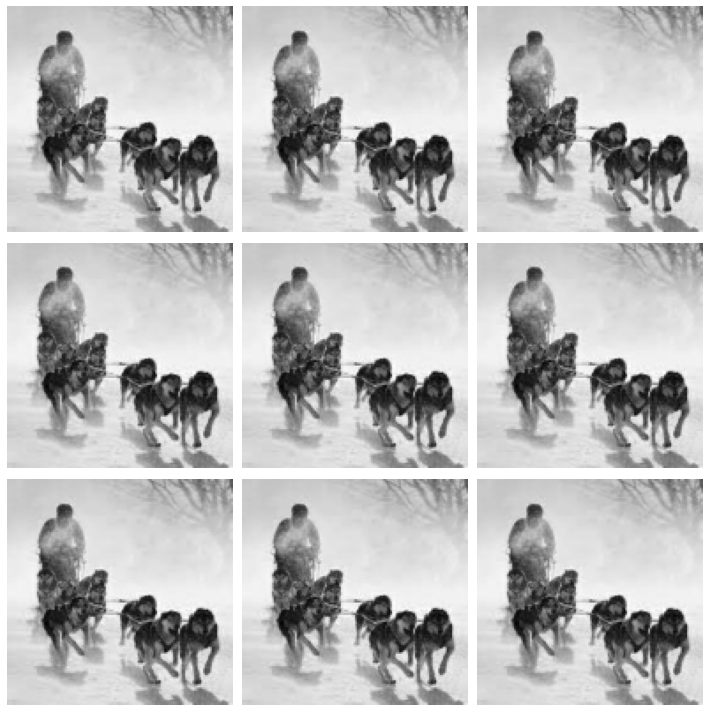

In [138]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
  plt.tight_layout()

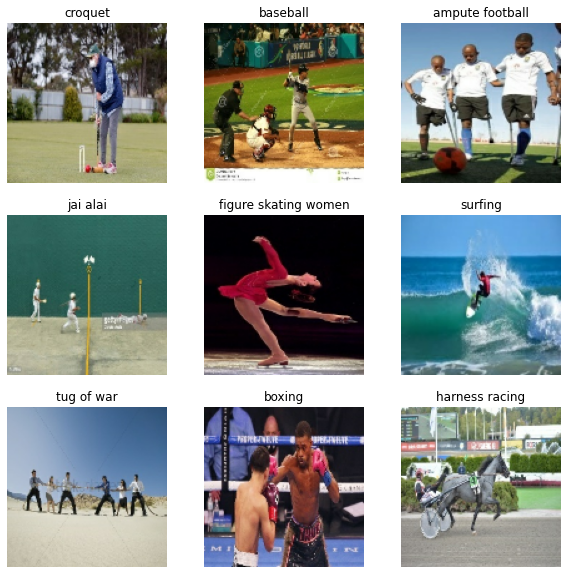

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [71]:
if kb.image_data_format() == 'channels_first':
    input_shape = (3, im_w, im_h)
else:
    input_shape = (im_w, im_h, 3)

model = Sequential([
  layers.Rescaling(1./255, input_shape=input_shape),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

In [72]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [73]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 128)      

In [74]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=15)

Epoch 1/15
681/681 [==============================] - 7s 10ms/step - loss: 4.2912 - accuracy: 0.0435 - val_loss: 3.8053 - val_accuracy: 0.1000
Epoch 2/15
681/681 [==============================] - 7s 10ms/step - loss: 3.3800 - accuracy: 0.1856 - val_loss: 2.9722 - val_accuracy: 0.2560
Epoch 3/15
681/681 [==============================] - 7s 9ms/step - loss: 2.6328 - accuracy: 0.3329 - val_loss: 2.5888 - val_accuracy: 0.3300
Epoch 4/15
681/681 [==============================] - 7s 9ms/step - loss: 2.1014 - accuracy: 0.4492 - val_loss: 2.3817 - val_accuracy: 0.3860
Epoch 5/15
681/681 [==============================] - 6s 9ms/step - loss: 1.6542 - accuracy: 0.5492 - val_loss: 2.5112 - val_accuracy: 0.4000
Epoch 6/15
681/681 [==============================] - 7s 9ms/step - loss: 1.2821 - accuracy: 0.6462 - val_loss: 2.4473 - val_accuracy: 0.4480
Epoch 7/15
681/681 [==============================] - 6s 9ms/step - loss: 0.9660 - accuracy: 0.7214 - val_loss: 2.7142 - val_accuracy: 0.4480
Epoc

In [144]:
if kb.image_data_format() == 'channels_first':
    input_sh = (3, im_w, im_h)
else:
    input_sh = (im_w, im_h, 3)

model1 = Sequential([
  layers.RandomFlip("vertical", input_shape=input_sh),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(100, name="outputs")])

In [145]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [147]:
model1.summary()

ValueError: ignored

In [150]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = EarlyStopping(monitor='loss', patience=3)

epochs = 15
history = model1.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  callbacks=[model_checkpoint_callback, early_stopping]
)

model1.load_weights(checkpoint_filepath)

Epoch 1/15
681/681 [==============================] - 12s 18ms/step - loss: 3.6091 - accuracy: 0.1303 - val_loss: 3.6081 - val_accuracy: 0.1360
Epoch 2/15
681/681 [==============================] - 12s 18ms/step - loss: 3.1987 - accuracy: 0.2107 - val_loss: 3.2583 - val_accuracy: 0.2220
Epoch 3/15
681/681 [==============================] - 12s 17ms/step - loss: 2.9547 - accuracy: 0.2616 - val_loss: 2.8282 - val_accuracy: 0.2920
Epoch 4/15
681/681 [==============================] - 12s 18ms/step - loss: 2.7648 - accuracy: 0.3013 - val_loss: 2.9062 - val_accuracy: 0.3100
Epoch 5/15
681/681 [==============================] - 12s 17ms/step - loss: 2.6137 - accuracy: 0.3306 - val_loss: 2.9472 - val_accuracy: 0.3240
Epoch 6/15
681/681 [==============================] - 12s 18ms/step - loss: 2.4995 - accuracy: 0.3569 - val_loss: 2.7559 - val_accuracy: 0.3280
Epoch 7/15
681/681 [==============================] - 12s 17ms/step - loss: 2.4105 - accuracy: 0.3767 - val_loss: 2.5988 - val_accuracy:

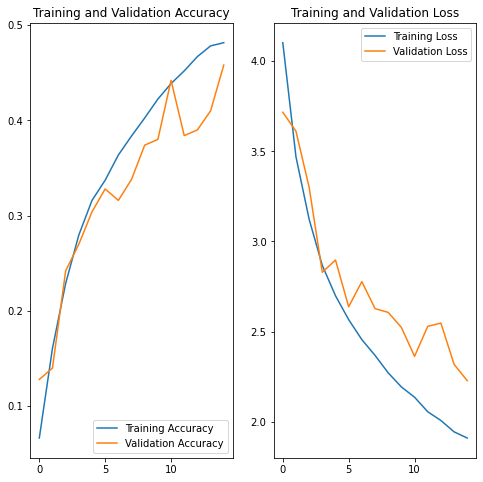

In [113]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [159]:
import sklearn.metrics as metrics

test_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(im_w, im_h),
    shuffle=False,
    class_mode='categorical')



model.fit(train_generator, 15)

metrics_train = model.evaluate(train_generator)
metrics_test = model.evaluate(test_generator)


print(f"TRAIN_SET: {metrics_train}")
print("--------------------------------------------")
print(f"TEST_SET: {metrics_test}")

# save the model
model.save("model_MaskDetect_25_epochs.h5")
print("Saved!")
y_predict_test = model.predict(test_generator, test_generator.samples / batch_size)

print(y_predict_test)


Found 500 images belonging to 100 classes.


RuntimeError: ignored

In [143]:
score = model.evaluate(test_generator,y_predict_test,verbose=0)
print(score)

matrix = confusion_matrix(test_generator.classes, y_predict_test)
matrix_text = [[str(y) for y in x] for x in matrix]
fig_matrix = ffc.create_annotated_heatmap(matrix, class_names, class_names)
fig_matrix.show()

ValueError: ignored

In [153]:
from tensorflow.keras.applications import MobileNetV2

model = MobileNetV2(
    input_shape=None,
    alpha=1.0,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

14536120/14536120 [==============================] - 0s 0us/step


In [158]:
from skimage.io import imread
data = np.empty((1, 224, 224, 3))
data[0] = imread('/content/drive/MyDrive/data-z3/train/archery/3.jpg')
data = preprocess_input(data)

predictions = model.predict(data)
print('Shape: {}'.format(predictions.shape))

FileNotFoundError: ignored